In [ ]:
!pip install syft  #If running this notebook on Google Colab

     |████████████████████████████████| 256kB 2.8MB/s 
     |████████████████████████████████| 204kB 43.3MB/s 
     |████████████████████████████████| 2.1MB 38.6MB/s 
     |████████████████████████████████| 256kB 45.6MB/s 
     |████████████████████████████████| 389kB 40.0MB/s 
     |████████████████████████████████| 81kB 26.4MB/s 
     |████████████████████████████████| 460kB 40.3MB/s 
     |████████████████████████████████| 51kB 17.3MB/s 
     |████████████████████████████████| 266kB 42.7MB/s 
     |████████████████████████████████| 122kB 42.9MB/s 
  Created wheel for zstd: filename=zstd-1.4.1.0-cp36-cp36m-linux_x86_64.whl size=1067070 sha256=fadab7e9e6ad7be2af36c2f369655804149e928de13cab092093501931e20ee9
  Stored in directory: /root/.cache/pip/wheels/66/3f/ee/ac08c81af7c1b24a80c746df669ea3cb37542d27877d66ccf4
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44105 sha256=64227058e2465565e5633680319e9fb83ec88e5a2a561a1c9af28d5981e4241c
  Stored in di

In [ ]:
!unzip thermalTrain.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import time

In [2]:
class Arguments():
    def __init__(self):
        self.batch_size = 12
        self.test_batch_size = 12
        self.epochs = 10
        self.lr = 0.02
        self.seed = 1
        self.log_interval = 1 # Log info at each batch
        self.precision_fractional = 3

args = Arguments()

_ = torch.manual_seed(args.seed)

In [3]:
import syft as sy  # import the Pysyft library
hook = sy.TorchHook(torch)  # hook PyTorch to add extra functionalities like Federated and Encrypted Learning

# simulation functions
def connect_to_workers(n_workers):
    return [
        sy.VirtualWorker(hook, id=f"worker{i+1}")
        for i in range(n_workers)
    ]
def connect_to_crypto_provider():
    return sy.VirtualWorker(hook, id="crypto_provider")

workers = connect_to_workers(n_workers=2)
crypto_provider = connect_to_crypto_provider()

/home/joybanerjee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joybanerjee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joybanerjee/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joybanerjee/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [4]:
# We don't use the whole dataset for efficiency purpose, but feel free to increase these numbers
def get_private_data_loaders(precision_fractional, workers, crypto_provider):
    
    def one_hot_of(index_tensor):
        """
        Transform to one hot tensor
        
        Example:
            [0, 3, 9]
            =>
            [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]
            
        """
        onehot_tensor = torch.zeros(*index_tensor.shape, 8) # 10 classes for MNIST
        onehot_tensor = onehot_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return onehot_tensor
        
    def secret_share(tensor):
        """
        Transform to fixed precision and secret share a tensor
        """
        return (
            tensor
            .fix_precision(precision_fractional=precision_fractional)
            .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
        )
    
    transformationTrain = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(size=(28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    transformationTest = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(size=(28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('./dataset/train/',transform=transformationTrain),
        batch_size=args.batch_size
    )
    

    private_train_loader = [
        (secret_share(data), 
         secret_share(one_hot_of(target)))
        for i, (data, target) in enumerate(train_loader)
    ]
    
    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('./dataset/test/',transform=transformationTest),
        batch_size=args.test_batch_size
    )
    
    private_test_loader = [
        (secret_share(data), 
         secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
    ]
    
    return private_train_loader, private_test_loader
    
    
private_train_loader, private_test_loader = get_private_data_loaders(
    precision_fractional=args.precision_fractional,
    workers=workers,
    crypto_provider=crypto_provider
)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def train(args, model, private_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(private_train_loader): # <-- now it is a private dataset
        start_time = time.time()
        
        optimizer.zero_grad()
        
        output = model(data)
        
        # loss = F.nll_loss(output, target)  <-- not possible here
        batch_size = output.shape[0]
        loss = ((output - target)**2).sum().refresh()/batch_size
        
        loss.backward()

        optimizer.step()

        if batch_idx % args.log_interval == 0:
            loss = loss.get().float_precision()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                epoch, batch_idx * args.batch_size, len(private_train_loader) * args.batch_size,
                100. * batch_idx / len(private_train_loader), loss.item(), time.time() - start_time))

In [7]:
def test(args, model, private_test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in private_test_loader:
            start_time = time.time()
            
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()

    correct = correct.get().float_precision()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct.item(), len(private_test_loader)* args.test_batch_size,
        100. * correct.item() / (len(private_test_loader) * args.test_batch_size)))
    return 100. * correct.item() / (len(private_test_loader) * args.test_batch_size)

In [8]:
model = Net()
try:
  model.load_state_dict(torch.load('littleThermalNet.pt'))
  print('Model found and loaded')
except Exception as e:
  print(e)

model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

Model found and loaded


<h2>Run Training</h2>

In [8]:
optimizer = optim.SGD(model.parameters(), lr=args.lr)
optimizer = optimizer.fix_precision() 
maxPercent = 0

for epoch in range(1, args.epochs + 1):
    train(args, model, private_train_loader, optimizer, epoch)
    currentPercent = test(args, model, private_test_loader)
    if currentPercent > maxPercent:
      print('Model Saved')
      torch.save(model.get().float_precision().state_dict(), 'littleThermalNet.pt')
      model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)
      maxPercent = currentPercent

Model found and loaded
Train Epoch: 1 [0/240 (0%)]	Loss: 0.004000	Time: 1.030s
Train Epoch: 1 [12/240 (5%)]	Loss: 0.041000	Time: 1.037s
Train Epoch: 1 [24/240 (10%)]	Loss: 0.045000	Time: 1.086s
Train Epoch: 1 [36/240 (15%)]	Loss: 0.106000	Time: 1.052s
Train Epoch: 1 [48/240 (20%)]	Loss: 0.077000	Time: 1.050s
Train Epoch: 1 [60/240 (25%)]	Loss: 0.070000	Time: 1.089s
Train Epoch: 1 [72/240 (30%)]	Loss: 0.035000	Time: 1.047s
Train Epoch: 1 [84/240 (35%)]	Loss: 0.007000	Time: 1.052s
Train Epoch: 1 [96/240 (40%)]	Loss: 0.009000	Time: 1.055s
Train Epoch: 1 [108/240 (45%)]	Loss: 0.039000	Time: 1.045s
Train Epoch: 1 [120/240 (50%)]	Loss: 0.041000	Time: 1.040s
Train Epoch: 1 [132/240 (55%)]	Loss: 0.096000	Time: 1.034s
Train Epoch: 1 [144/240 (60%)]	Loss: 0.082000	Time: 1.052s
Train Epoch: 1 [156/240 (65%)]	Loss: 0.019000	Time: 1.049s
Train Epoch: 1 [168/240 (70%)]	Loss: 0.094000	Time: 1.059s
Train Epoch: 1 [180/240 (75%)]	Loss: 0.134000	Time: 1.054s
Train Epoch: 1 [192/240 (80%)]	Loss: 0.118000

In [9]:
import cv2
import numpy as np
from PIL import Image

In [10]:
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

In [11]:
def secret_share(tensor,precision_fractional,workers,crypto_provider):
    """
    Transform to fixed precision and secret share a tensor
    """
    return (
        tensor
        .fix_precision(precision_fractional=precision_fractional)
        .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
    )
def image_loader(image_name):
    loader = transforms.Compose([transforms.Grayscale(),                                 
                                transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))   
                                ])
    image = loader(image_name)
    image = image.cpu()
    image = torch.autograd.Variable(image)
    image = secret_share(image,args.precision_fractional,workers,crypto_provider)
    return image

In [12]:
labels = ['Nothing','Human','Coffee','Noodles','Phone','Laptop','Pi','Hand']

<h2>Test Model</h2>

In [13]:
img = cv2.imread('52.png', 0)
img = Image.fromarray(img)
out = model(image_loader(img))
labels[out.get().float_precision().data.numpy().argmax()]

'Human'

In [24]:
import socket
import threading
print('If you are running this on Google Colab, then copy and paste the following IP to your Pi : ',socket.gethostbyname(socket.getfqdn(socket.gethostname())))

from flask import Flask, request, Response,jsonify
import io
import base64


If you are running this on Google Colab, then copy and paste the following IP to your Pi 127.0.1.1


<h3>Disable Logging from Flask</h3>

In [15]:
import logging
log = logging.getLogger('werkzeug')
log.setLevel(logging.ERROR)

<h3>Algorithm for Image Scrambling and Unscrambling</h3>

source : https://github.com/AtheMathmo/ImageEncryptor

In [16]:
def basic_decrypt_unscramble(im):
    y_size,x_size = im.shape
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    for x in range(x_size):
        for y in range(y_size):
            pixel = im[y, x]
            im[y, x] = tuple(int(c**3 % 256) for c in pixel)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    return im
def basic_encrypt_scramble(im):
    y_size,x_size = im.shape
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    for x in range(x_size):
        for y in range(y_size):
            pixel = im[y, x]
            coprime_pixel = ((c+1 if c % 2 == 0 else c) for c in pixel)
            im[y, x] = tuple(int(c**43 % 256) for c in coprime_pixel)
    im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
    return im

<h3>Running the Webserver</h3>

In [17]:
app = Flask(__name__)
@app.route('/savepic',methods=['POST'])  ##POST : image, name
def savereq():
    try:
        image_stream = io.BytesIO()
        image_stream.write(base64.b64decode(request.form['image']))
        image_stream.seek(0)
        img = Image.open(image_stream)
        img = Image.fromarray(basic_decrypt_unscramble(np.array(img)))
        if not os.path.exists('./dataset/'+request.form['name']):
            os.makedirs('./dataset/'+request.form['name'])
            no_of_files = '0'
        else:
            no_of_files = str(len(os.listdir('./dataset/'+request.form['name'])))
        img.save('./dataset/'+request.form['name']+'/'+no_of_files+'.png')
        return 'OK'
    except:
        return 'NOK'

@app.route('/train',methods=['POST'])
def train():
    model = Net()
    try:
      model.load_state_dict(torch.load('littleThermalNet.pt'))
      print('Model found and loaded')
    except Exception as e:
      print(e)

    model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)
    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optimizer.fix_precision() 
    maxPercent = 0
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, private_train_loader, optimizer, epoch)
        currentPercent = test(args, model, private_test_loader)
        if currentPercent > maxPercent:
          print('Model Saved')
          torch.save(model.get().float_precision().state_dict(), 'littleThermalNet.pt')
          model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)
          maxPercent = currentPercent
            
    return 'OK'
            
@app.route('/freshtrain',methods=['POST'])
def fresh():
    model = Net()
    try:
      model.load_state_dict(torch.load('littleThermalNet.pt'))
      print('Model found and loaded')
    except Exception as e:
      print(e)

    model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optimizer.fix_precision() 
    maxPercent = 0

    
    for epoch in range(1, args.epochs + 1):
        train(args, model, private_train_loader, optimizer, epoch)
        currentPercent = test(args, model, private_test_loader)
        if currentPercent > maxPercent:
          print('Model Saved')
          torch.save(model.get().float_precision().state_dict(), 'littleThermalNet.pt')
          model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)
          maxPercent = currentPercent
            
    return 'OK'
            
@app.route('/infer',methods=['POST'])
def inferreq():
    image_stream = io.BytesIO()
    image_stream.write(base64.b64decode(request.form['image']))
    image_stream.seek(0)
    img = Image.open(image_stream)
    img = basic_decrypt_unscramble(np.array(img))
    out = model(image_loader(Image.fromarray(img)))
    result = out.get().float_precision().data.numpy().argmax()
    return labels[result]

threading.Thread(target=app.run, kwargs={'host':'0.0.0.0','port':5000}).start() 

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


<h2>Test Image Scrambling</h2>

In [19]:
import matplotlib.pyplot as plt

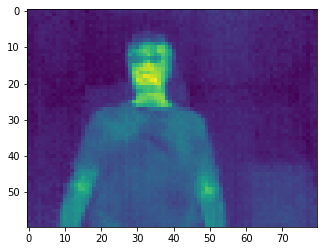

In [20]:
im = cv2.imread('human.png',0)
plt.imshow(im)

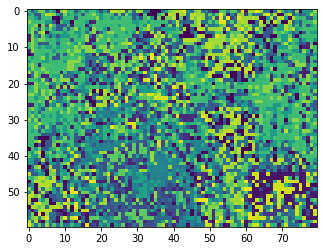

In [21]:
out = basic_encrypt_scramble(im)
plt.imshow(out)

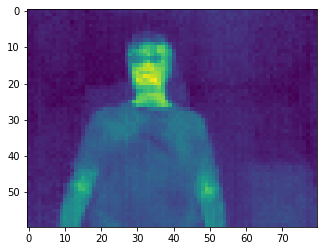

In [23]:
out = basic_decrypt_unscramble(out)
plt.imshow(out)